## InterpretML tutorial for model explainability
### CHAPTER 09 - *Other popular XAI frameworks*

From **Applied Machine Learning Explainability Techniques** by [**Aditya Bhattacharya**](https://www.linkedin.com/in/aditya-bhattacharya-b59155b6/), published by **Packt**

### Objective

Let's explore another interesting model explainability framework available in Python - [InterpretML from Microsoft](https://interpret.ml/). We will use InterpretML to explain a ML model trained on the [Hepatitis Dataset](https://archive.ics.uci.edu/ml/datasets/hepatitis) similar to the [ELI5 Tutorial](https://github.com/PacktPublishing/Applied-Machine-Learning-Explainability-Techniques/blob/main/Chapter09/ELI5_example.ipynb).

InterpretML comes with two different options for model interpretability : Using Explainable Glass-Box Models (EBM) and explainability black-box models with known interpretable techniques. We will cover both the approaches in this notebook.

### Installing the modules

Install the following libraries in Google Colab or your local environment, if not already installed.

In [ ]:
!pip install --upgrade pandas numpy matplotlib seaborn scikit-learn interpret

### Loading the modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

import interpret as iml
from interpret.glassbox import ExplainableBoostingClassifier, DecisionListClassifier, ClassificationTree
from interpret.blackbox import LimeTabular, ShapKernel, MorrisSensitivity, PartialDependence
from interpret.data import ClassHistogram

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from IPython import display

np.random.seed(123)

### About the data

**Hepatitis Dataset - UCI Machine Learning Repository**

The Hepatitis Dataset is a dataset with 155 records and 20 features of different types for the detection of the hepatitis disease. I have added the dataset in the project reposity for easy discovery but more details about this data can be found at - [https://archive.ics.uci.edu/ml/datasets/hepatitis](https://archive.ics.uci.edu/ml/datasets/hepatitis)

### Loading the data

In [2]:
data  = pd.read_csv('datasets/Hepatitis_Data/hepatitis.data', header=None)
data.columns = ['Class','AGE','SEX','STEROID','ANTIVIRALS','FATIGUE',
                'MALAISE','ANOREXIA','LIVER BIG','LIVER FIRM','SPLEEN PALPABLE',
                'SPIDERS','ASCITES','VARICES','BILIRUBIN', 'ALK PHOSPHATE',
                'SGOT', 'ALBUMIN', 'PROTIME', 'HISTOLOGY'].copy()
data.head()

,Class,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
0,2,30,2,1,2,2,2,2,1,2,2,2,2,2,1.00,85,18,4.0,?,1
1,2,50,1,1,2,1,2,2,1,2,2,2,2,2,0.90,135,42,3.5,?,1
2,2,78,1,2,2,1,2,2,2,2,2,2,2,2,0.70,96,32,4.0,?,1
3,2,31,1,?,1,2,2,2,2,2,2,2,2,2,0.70,46,52,4.0,80,1
4,2,34,1,2,2,2,2,2,2,2,2,2,2,2,1.00,?,200,4.0,?,1


2    123
1     32
Name: Class, dtype: int64

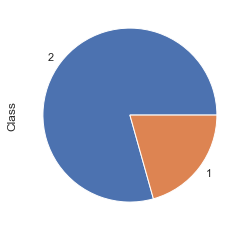

In [3]:
data['Class'].value_counts().plot(kind='pie')
data['Class'].value_counts()

In [4]:
data.shape

(155, 20)

In [5]:
# Reading the dataset description
with open('datasets/Hepatitis_Data/hepatitis.names') as f:
    contents = f.read()
    print(contents)

1. Title: Hepatitis Domain

2. Sources:
     (a) unknown
     (b) Donor: G.Gong  (Carnegie-Mellon University) via 
                   Bojan Cestnik
                   Jozef Stefan Institute
                   Jamova 39
                   61000 Ljubljana
                   Yugoslavia (tel.: (38)(+61) 214-399 ext.287) }
     (c) Date: November, 1988

3. Past Usage:
    1. Diaconis,P. & Efron,B. (1983).  Computer-Intensive Methods in 
       Statistics.  Scientific American, Volume 248.
       -- Gail Gong reported a 80% classfication accuracy
    2. Cestnik,G., Konenenko,I, & Bratko,I. (1987). Assistant-86: A
       Knowledge-Elicitation Tool for Sophisticated Users.  In I.Bratko
       & N.Lavrac (Eds.) Progress in Machine Learning, 31-45, Sigma Press.
       -- Assistant-86: 83% accuracy

4. Relevant Information:
    Please ask Gail Gong for further information on this database.

5. Number of Instances: 155

6. Number of Attributes: 20 (including the class attribute)

7. Attribute info

The dataset contains '?' which we will treat as missing values. But we need to explicitly replace '?' with `np.nan` to treat these values as missing values.

In [6]:
data = data.replace('?', np.nan)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Class            155 non-null    int64 
 1   AGE              155 non-null    int64 
 2   SEX              155 non-null    int64 
 3   STEROID          154 non-null    object
 4   ANTIVIRALS       155 non-null    int64 
 5   FATIGUE          154 non-null    object
 6   MALAISE          154 non-null    object
 7   ANOREXIA         154 non-null    object
 8   LIVER BIG        145 non-null    object
 9   LIVER FIRM       144 non-null    object
 10  SPLEEN PALPABLE  150 non-null    object
 11  SPIDERS          150 non-null    object
 12  ASCITES          150 non-null    object
 13  VARICES          150 non-null    object
 14  BILIRUBIN        149 non-null    object
 15  ALK PHOSPHATE    126 non-null    object
 16  SGOT             151 non-null    object
 17  ALBUMIN          139 non-null    ob

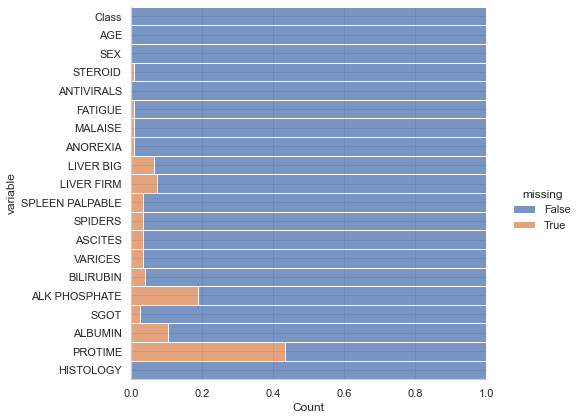

In [8]:
# Let's check missing values
sns.displot(
    data=data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    height=6,
    aspect=1.2
)
plt.show()

In [9]:
numerical_features = ['AGE', 'BILIRUBIN', 'ALK PHOSPHATE', 'SGOT', 'PROTIME', 'ALBUMIN']
target = 'Class'
categorical_features = list(set(data.columns) - set([target]) - set(numerical_features))

From the initial inspection, we can clearly see that the dataset is imbalanced with 79% of the data belonging to LIVE class (class 2) and 21% of the data belonging to DIE class (class 1). The dataset also has missing values, outliers and categorical values, which we need to address during the pre-processing step.

### Data Preprocessing

Let's start the data preprocessing by doing a simplified data imputation. The decision to do data imputation was based on the fact that we have a small dataset with only 155 records. Dropping missing values might not be a good idea. Our simplified data imputation technique will involve replacing missing values with median values for numerical features and mode values for categorical features.

In [10]:
# Handling missing values
## for numerical features
for feature in numerical_features:
    data[feature] = data[feature].fillna(data[feature].median())
## for categorical features
for feature in categorical_features:
    data[feature] = data[feature].fillna(data[feature].mode()[0])

In [11]:
label = data[target].copy()
features = data.drop(columns=target)

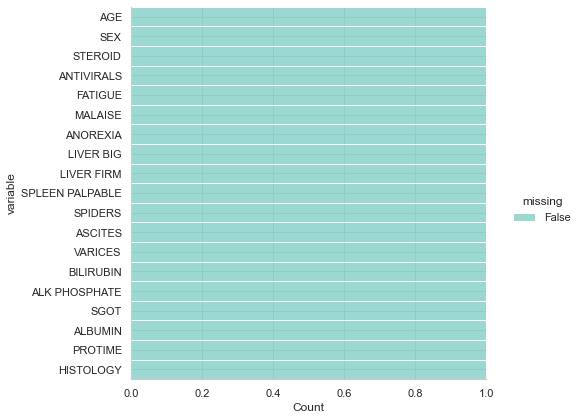

In [12]:
# Let's check missing values
sns.displot(
    data=features.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    height=6,
    aspect=1.2,
    palette= 'GnBu'
)
plt.show()

So, no missing values anymore! Let's perform one-hot encoding now using `pandas.get_dummies()`

In [13]:
# One-Hot Encoding
encoded = pd.get_dummies(features, prefix_sep='=', columns=categorical_features)
encoded.head()

,AGE,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,ANOREXIA=1,ANOREXIA=2,LIVER BIG=1,LIVER BIG=2,FATIGUE=1,FATIGUE=2,SPIDERS=1,SPIDERS=2,LIVER FIRM=1,LIVER FIRM=2,MALAISE=1,MALAISE=2,VARICES=1,VARICES=2,SPLEEN PALPABLE=1,SPLEEN PALPABLE=2,ASCITES=1,ASCITES=2,ANTIVIRALS=1,ANTIVIRALS=2,HISTOLOGY=1,HISTOLOGY=2,STEROID=1,STEROID=2,SEX=1,SEX=2
0,30,1.00,85,18,4.0,61.0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,1
1,50,0.90,135,42,3.5,61.0,0,1,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0
2,78,0.70,96,32,4.0,61.0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0
3,31,0.70,46,52,4.0,80,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,1,1,0
4,34,1.00,85.0,200,4.0,61.0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0


In [14]:
encoded.shape

(155, 32)

In [15]:
feature_types = (['continuous'] * len(numerical_features)) + (['categorical'] *( 2 * len(categorical_features)))
len(feature_types)

32

In this tutorial, we have done the basic bare minimum data preparation steps required for training a model as we are more interested in the model explainability part using InterpretML. But feel free to try out additional data preparation steps to get a better model. In the next part, let us train a Random Forest classifier model.

### Training a model

Now, we will train a Random Forest model with minimum hyper-parameter tuning. I would recommend you to do a more rigorous hyper-parameter tuning to get a better model.

In [16]:
x_train, x_test, y_train, y_test = train_test_split(encoded, label, test_size=0.3, random_state=123)

In [65]:
model = RandomForestClassifier(n_estimators=100, min_samples_split = 2, random_state=123).fit(x_train, y_train)

In [66]:
model.score(x_test, y_test)

0.851063829787234

In [67]:
y_pred = model.predict(x_test)

In [68]:
roc_auc_score(y_test, y_pred)

0.6864864864864866

So, as we can see from a quick evaluation of the trained model on the test data, we are getting an accuracy of 85% but an AUC score of 70%. This is because the dataset is not balanced and hence a metric like accuracy can be very misleading. 
Like all other tutorials covered in this chapter, we will focus more on the model explainability part with interpret ml, rather than building an efficient ML model.

## Model explainability with Interpret ML

### a. Explaining with glass-box models which can be used as surrogate explainers

In [60]:
# Explore the dataset

In [69]:
hist = ClassHistogram().explain_data(x_train, y_train, name = 'Training Data')
iml.show(hist)

<!-- http://127.0.0.1:7001/1623409358408/ -->

#### Explaining with explainable glass-box models

In [71]:
ebm = ExplainableBoostingClassifier(feature_types=feature_types)
ebm.fit(x_train, y_train)

ExplainableBoostingClassifier(feature_names=['AGE', 'BILIRUBIN',
                                             'ALK PHOSPHATE', 'SGOT', 'ALBUMIN',
                                             'PROTIME', 'ANOREXIA=1',
                                             'ANOREXIA=2', 'LIVER BIG=1',
                                             'LIVER BIG=2', 'FATIGUE=1',
                                             'FATIGUE=2', 'SPIDERS=1',
                                             'SPIDERS=2', 'LIVER FIRM=1',
                                             'LIVER FIRM=2', 'MALAISE=1',
                                             'MALAISE=2', 'VARICES=1',
                                             'VARICES=2', 'SPLEEN PALPABLE=1',
                                             'SPLEEN PALPABLE=2', 'ASCITES=1',
                                             'ASCITES=2', 'ANTIVI...
                                             'continuous', 'continuous',
                                             'c

In [72]:
# Showing Global Explanations
ebm_global = ebm.explain_global()
iml.show(ebm_global)

<!-- http://127.0.0.1:7001/1622615388744/ -->

In [73]:
# Local explanation using EBM
ebm_local = ebm.explain_local(x_test[5:6], y_test[5:6], name = 'Local Explanation')
iml.show(ebm_local)

<!-- http://127.0.0.1:7001/1623471415560/ -->

Using InterpretML, glass-box models like EBM can be used an surrogate explainers for both global and local explainability.

#### Explaining with Decision Rule Lists

In [74]:
dlc = DecisionListClassifier(feature_types=feature_types)
dlc.fit(x_train, y_train)

# Showing Global Explanations
dlc_global = dlc.explain_global()
iml.show(dlc_global)

<!-- http://127.0.0.1:7001/1622615766216/ -->

#### Explaining with Decision Trees

In [75]:
dtc = ClassificationTree(feature_types=feature_types)
dtc.fit(x_train, y_train)

# Showing Global Explanations
dtc_global = dtc.explain_global()
iml.show(dtc_global)

<!-- http://127.0.0.1:7001/1623489344264/ -->

In [76]:
# Use all white-box global explanations in the same dashboard

iml.show([hist, ebm_global, ebm_local, dlc_global, dtc_global])

<!-- http://127.0.0.1:7001/1623489673096/ -->
 Open in new window

### b. Explaining black-box models using InterpretML

In [77]:
#The InterpretML Blackbox explainers need a predict function, and optionally a dataset
lime = LimeTabular(predict_fn=model.predict_proba, data=x_train.astype('float').values, random_state=123)

#Select the instances to explain, optionally pass in labels if you have them
lime_local = lime.explain_local(x_test[:5].astype('float').values, y_test[:5], name='LIME')

iml.show(lime_local)

<!-- http://127.0.0.1:7001/1623494519688/ -->

In [78]:
# SHAP explanation
background_val = np.median(x_train.astype('float').values, axis=0).reshape(1, -1)
shap = ShapKernel(predict_fn=model.predict_proba, data=background_val, feature_names= list(x_train.columns))
shap_local = shap.explain_local(x_test[:5].astype('float').values, y_test[:5], name='SHAP')
iml.show(shap_local)

  0%|          | 0/5 [00:00<?, ?it/s]

<!-- http://127.0.0.1:7001/1621373317896/ -->

In [79]:
sensitivity = MorrisSensitivity(predict_fn=model.predict_proba, 
                                data=x_train.astype('float').values,
                                feature_names=list(x_train.columns),
                                feature_types=feature_types)
sensitivity_global = sensitivity.explain_global(name="Global Sensitivity")

iml.show(sensitivity_global)

<!-- http://127.0.0.1:7001/1623480299016/ -->

In [80]:
pdp = PartialDependence(predict_fn=model.predict_proba,
                        data=x_train.astype('float').values,
                        feature_names=list(x_train.columns),
                        feature_types=feature_types)
pdp_global = pdp.explain_global(name='Partial Dependence')

iml.show(pdp_global)

<!-- http://127.0.0.1:7001/1621391838664/ -->

In [81]:
# Putting all the explainers in one dashboard
iml.show([lime_local, shap_local, sensitivity_global, pdp_global])

<!-- http://127.0.0.1:7001/1621392312840/ -->
 Open in new window

### Final Thoughts

Overall, the framework has a lot of potential, but it does have some limitations. It is restricted to tabular datasets, it is not compatible with model frameworks like PyTorch, TensorFlow, H20 and I felt the model explanation methods are also limited. Improving these limitation can definitely increase the adoption of this framework. 

### Reference

1. Dataset link - [Hepatitis Dataset](https://archive.ics.uci.edu/ml/datasets/hepatitis)
2. InterpretML Github project - https://github.com/interpretml/interpret
3. InterpretML Documentation - https://interpret.ml/
4. Other notebook examples: https://github.com/interpretml/interpret/tree/develop/examples/python/notebooks
5. Some of the utility functions and code are taken from the GitHub Repository of the author - Aditya Bhattacharya https://github.com/adib0073
6. Want to connect with the author of this chapter? You can reach out by any means mentioned here: https://aditya-bhattacharya.net/contact-me/